In [4]:
%store -r cluster_map

In [5]:
cluster_map

,data_index,cluster
0,0,3
1,1,2
2,2,2
3,3,3
4,4,2
...,...,...
95,95,4
96,96,2
97,97,2
98,98,2


In [6]:
%store -r data_dict

In [7]:
print(len(data_dict))

100


In [8]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
!python -m spacy download en

/Users/himanshusaroha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [10]:
nlp = spacy.load('en_core_web_sm')

/Users/himanshusaroha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
%store -r cleanDocx

/Users/himanshusaroha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
import warnings
warnings.filterwarnings('ignore')

/Users/himanshusaroha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
print(len(cleanDocx))

100


In [14]:
%store -r dfObj1

In [15]:
dfObj1

,0
0,"['[""[\'available online .sciencedirect. \\ava..."
1,"['[""[\'expert systems with applications (2018..."
2,"['[""[\'expert systems with applications (2018..."
3,"['[""[\'egyptian informatics journal (xxxx) \\..."
4,"['[""[\'journal king saud university – compute..."
...,...
95,"['[""[\'contents lists available sciencedirect..."
96,"['[""[\'decision support systems (2020) 113280..."
97,"['[""[\'engineering applications artiﬁcial int..."
98,"['[""[\'user identiﬁcation social networks\\th..."


In [16]:
data = dfObj1.values.tolist()

In [17]:
len(data)

100

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [19]:
data_words = list(sent_to_words(data))
print(data_words[:1])

[['available', 'online', 'sciencedirect', 'available', 'online', 'sciencedirect', 'sciencedirect', 'sciencedirect', 'procedia', 'computer', 'science', 'procedia', 'computer', 'science', 'procedia', 'computer', 'science', 'elsevier', 'locate', 'procedia', 'elsevier', 'locate', 'procedia', 'fifth', 'information', 'systems', 'international', 'conference', 'fifth', 'information', 'systems', 'international', 'conference', 'sentiment', 'analysis', 'social', 'media', 'application', 'systematic', 'sentiment', 'analysis', 'social', 'media', 'application', 'systematic', 'literature', 'review', 'literature', 'review', 'zulfadzli', 'drus', 'haliyana', 'khalid', 'zulfadzli', 'drus', 'haliyana', 'khalid', 'azman', 'hashim', 'international', 'business', 'school', 'kuala', 'lumpur', 'malaysia', 'azman', 'hashim', 'international', 'business', 'school', 'kuala', 'lumpur', 'malaysia', 'abstract', 'abstract', 'this', 'paper', 'report', 'review', 'sentiment', 'analysis', 'social', 'media', 'that', 'explore

In [20]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [21]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['sciencedirect sciencedirect sciencedirect sciencedirect procedia computer science procedia computer science procedia computer science procedia procedia information system conference information system conference sentiment analysis medium application sentiment analysis medium application literature review literature review zulfadzli drus haliyana khalid zulfadzli drus haliyana khalid azman business school kuala lumpur malaysia azman business school kuala lumpur malaysia paper report review sentiment analysis medium explore method medium platform use paper report review sentiment analysis medium explore method medium platform use application medium contain amount datum upload user form text video photo application medium contain amount datum upload user form text video photo datum convert information use sentiment analysis review study datum convert information use sentiment analysis review study publish undertake use follow trust database include emerald publish undertake use follow t

In [22]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  )
# num chars > 3
                             # max_features=50000,             
# max number of uniq words    )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [23]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [24]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2506900.9547517775
Perplexity:  623.6512813018077
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [25]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [26]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))


Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -547393.7176522564
Model Perplexity:  763.4917678261962


In [27]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names

print(len(data))
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(88).style.applymap(color_green).applymap(make_bold)
df_document_topics

100


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc3,0.000000,0.210000,0.000000,0.000000,0.000000,0.000000,0.790000,0.000000,0.000000,0.000000,6
Doc4,0.000000,0.900000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc5,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.880000,0.000000,0.000000,0.000000,6
Doc6,0.000000,0.440000,0.000000,0.000000,0.000000,0.000000,0.560000,0.000000,0.000000,0.000000,6
Doc7,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.880000,0.000000,0.000000,0.000000,6
Doc8,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc9,0.000000,0.430000,0.000000,0.000000,0.000000,0.500000,0.070000,0.000000,0.000000,0.000000,5


In [28]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head(10)

,abbreviation,ability,absence,abstract,abstraction,abuse,academia,academic,academy,accelerate,...,yoon,york,ysis,yuan,zeng,zhai,zhang,zhao,zhong,zhou
Topic0,1.054996,1.066450,1.067664,0.869770,0.878954,0.952991,0.949451,0.897556,0.927982,0.920965,...,0.872500,0.882906,1.139216,1.058935,0.977944,0.852891,0.836502,0.981387,0.948720,0.913859
Topic1,3.609603,13.522816,3.405321,21.273157,2.237529,2.211563,2.214286,2.881636,4.621709,3.160580,...,2.387094,14.122318,2.429478,5.417883,4.534261,3.496922,5.390712,15.615870,3.261350,13.259086
Topic2,0.838018,1.084548,0.814479,1.084807,0.912964,1.063327,0.925191,0.789590,0.868767,0.811172,...,0.737433,1.177387,0.831745,0.830315,0.971620,1.055237,0.907475,0.926176,1.008409,1.266659
Topic3,1.049135,0.867500,0.738870,1.122561,0.783811,1.007381,0.873292,0.958532,0.974741,1.042597,...,0.948779,0.839654,0.840653,1.102615,0.969379,0.846232,0.886997,1.072033,0.823835,1.044894
Topic4,1.547054,2.066137,1.279330,5.330401,1.328044,1.582540,0.838270,0.864341,1.150777,1.128017,...,1.015327,1.574977,0.962506,0.874919,1.036042,1.166660,0.887557,1.622921,0.969050,1.493889
Topic5,1.430965,2.012039,1.181689,4.412731,1.030906,1.247141,1.046099,1.046575,1.141384,0.877054,...,0.976949,1.744591,0.690071,1.437621,0.901836,1.078547,1.240224,1.583021,0.860020,2.013042
Topic6,1.808494,4.992445,2.079185,14.013678,1.330085,0.890894,0.968127,0.878374,1.397568,1.883870,...,0.871131,3.339024,1.044310,1.041608,1.577248,2.669331,1.820477,3.646023,1.064525,4.980415
Topic7,0.808918,0.847949,0.885615,0.908377,1.021855,0.980299,0.834588,0.888630,0.923083,0.821998,...,0.863983,0.860781,0.826731,0.830842,1.021100,0.888345,0.891197,1.007810,0.892581,1.008698
Topic8,1.000646,1.617499,1.097025,1.688844,1.014185,0.920724,0.849665,0.884063,1.129861,0.905808,...,0.821690,1.597825,1.024878,1.139745,0.988052,1.119047,1.097812,1.126821,0.974398,1.226490
Topic9,0.907713,1.138250,0.941675,1.827146,0.858276,0.904482,0.844608,0.869307,0.800188,0.953022,...,0.815541,1.400704,0.940657,1.038711,1.145261,1.148574,1.073894,1.001945,0.968805,1.213524


In [29]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,process,datum,use,time,base,information,mining,application,case,practice,number,business,model,activity,research
Topic 1,review,datum,study,use,research,mining,base,model,analysis,process,information,method,text,journal,application
Topic 2,use,study,research,datum,information,model,process,review,base,support,journal,topic,result,analysis,text
Topic 3,review,use,process,analysis,information,study,user,base,mining,sentiment,model,datum,medium,conference,text
Topic 4,study,datum,use,review,patient,text,care,health,model,personality,analysis,result,healthcare,include,research
Topic 5,use,datum,review,mining,study,fraud,model,base,research,text,algorithm,method,information,journal,machine
Topic 6,use,study,text,datum,review,feature,base,technique,algorithm,method,document,research,learn,approach,classification
Topic 7,study,approach,base,personality,use,model,datum,research,sentiment,process,application,journal,report,mining,review
Topic 8,datum,use,study,model,mining,article,review,research,information,base,quality,technique,text,journal,approach
Topic 9,use,method,text,review,study,datum,base,research,feature,document,information,approach,technique,journal,model


In [30]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.    0.99  0.    0.    0.02  0.01  0.1   0.    0.    0.  ]
 [ 0.   -0.1   0.    0.    0.03  0.01  0.99  0.    0.    0.  ]]
Perc of Variance Explained: 
 [0.39 0.48]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

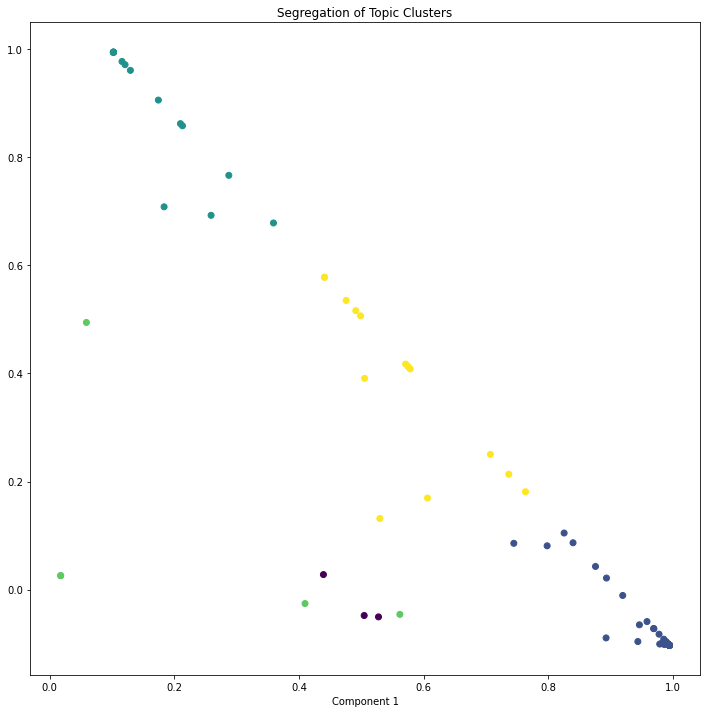

In [33]:
# Plot
fig = plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [34]:
fig.savefig('Segregation of topic clusters.png', dpi=100, bbox_inches='tight')

In [35]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["Machine learning algorith future technology"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['study', 'text', 'datum', 'review', 'feature', 'base', 'technique', 'algorithm', 'method', 'document', 'research', 'learn', 'approach']
classification
